In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

C:\Users\jhyang\AppData\Local\Temp\ipykernel_2152\656567117.py:47: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u[n + 1, 1:-1] = spsolve(A, b)


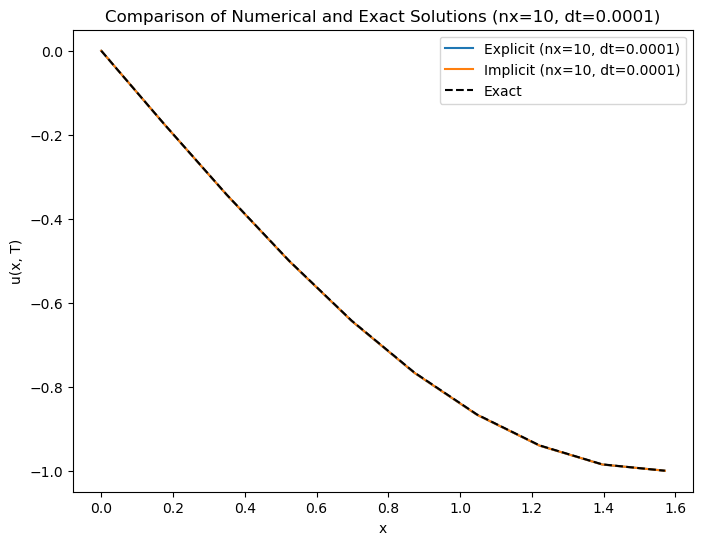

nx=10, alpha=0.1
Relative error (Explicit): 8.35e-04
Relative error (Implicit): 6.88e-04
--------------------------------------------------


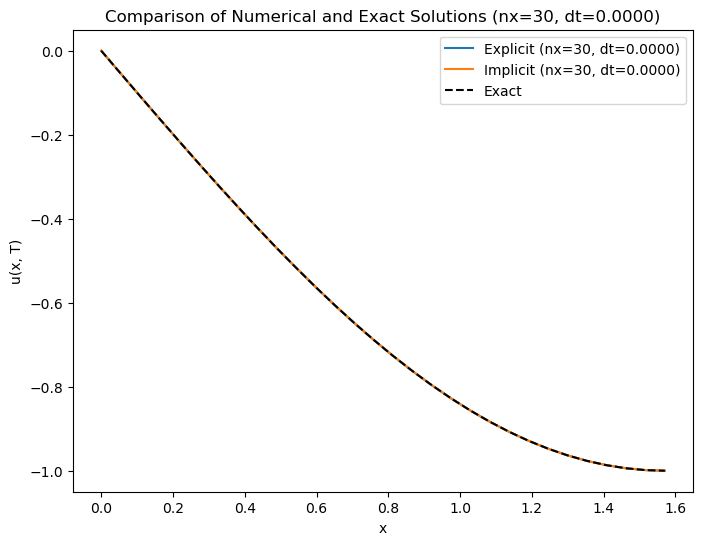

nx=30, alpha=0.01
Relative error (Explicit): 5.20e-05
Relative error (Implicit): 5.06e-05
--------------------------------------------------


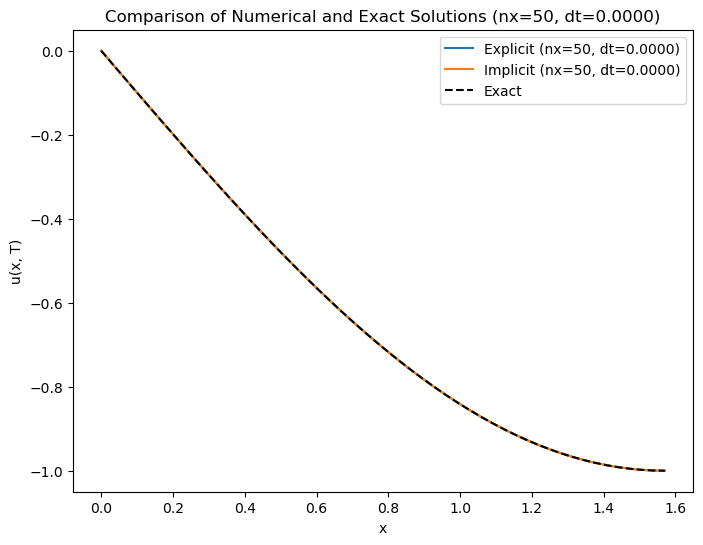

nx=50, alpha=0.01
Relative error (Explicit): 1.86e-05
Relative error (Implicit): 1.81e-05
--------------------------------------------------


In [6]:
# Parameters
L = np.pi / 2  # Spatial domain length
T = np.pi  # End time of the simulation

# Exact solution function for comparison
def exact_solution(x, t_val):
    return np.sin(x) * np.cos(t_val)

# Boundary conditions function
def boundary_conditions(u, t_val):
    u[0] = 0  # u(0, t) = 0
    u[-1] = np.cos(t_val)  # u(L, t) = cos(t)

# Source term function
def source_term(x, t_val):
    return -np.sin(x) * np.sin(t_val) + np.sin(x) * np.cos(t_val)

# Numerical solver
def solve_1d_heat(nx, alpha, method="explicit"):
    dx = L / (nx - 1)
    dt = alpha * dx**2  # Time step size for explicit method
    nt = int(T / dt) + 1
    dt = T / (nt - 1)  # Adjust dt to ensure exact time division
    
    x = np.linspace(0, L, nx)
    t = np.linspace(0, T, nt)
    
    u = np.zeros((nt, nx))
    u[0, :] = np.sin(x)  # Initial condition
    
    if method == "explicit":
        for n in range(0, nt - 1):
            boundary_conditions(u[n, :], t[n])
            for i in range(1, nx - 1):
                u[n + 1, i] = (u[n, i]
                               + alpha * (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1])
                               + dt * source_term(x[i], t[n]))
            boundary_conditions(u[n + 1, :], t[n + 1])
    
    elif method == "implicit":
        A = diags([-alpha, 1 + 2 * alpha, -alpha], [-1, 0, 1], shape=(nx - 2, nx - 2)).toarray()
        for n in range(0, nt - 1):
            boundary_conditions(u[n, :], t[n])
            b = u[n, 1:-1] + dt * source_term(x[1:-1], t[n])
            b[0] += alpha * 0  # Adjust for boundary condition at left end
            b[-1] += alpha * np.cos(t[n + 1])  # Adjust for boundary condition at right end
            u[n + 1, 1:-1] = spsolve(A, b)
            boundary_conditions(u[n + 1, :], t[n + 1])
    
    return x, t, u

# Error and plotting
grid_settings = [
    {'nx': 10, 'alpha': 0.1},
    {'nx': 30, 'alpha': 0.01},
    {'nx': 50, 'alpha': 0.01}
]

for setting in grid_settings:
    nx, alpha = setting['nx'], setting['alpha']
    x, t, u_explicit = solve_1d_heat(nx, alpha, method="explicit")
    _, _, u_implicit = solve_1d_heat(nx, alpha, method="implicit")
    
    u_exact = exact_solution(x, T)
    norm_u_exact = np.linalg.norm(u_exact)
    
    error_explicit = np.linalg.norm(u_explicit[-1, :] - u_exact) / norm_u_exact
    error_implicit = np.linalg.norm(u_implicit[-1, :] - u_exact) / norm_u_exact
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, u_explicit[-1, :], label=f'Explicit (nx={nx}, dt={alpha*dx**2:.4f})')
    plt.plot(x, u_implicit[-1, :], label=f'Implicit (nx={nx}, dt={alpha*dx**2:.4f})')
    plt.plot(x, u_exact, 'k--', label='Exact')
    plt.xlabel('x')
    plt.ylabel('u(x, T)')
    plt.title(f'Comparison of Numerical and Exact Solutions (nx={nx}, dt={alpha*dx**2:.4f})')
    plt.legend()
    plt.show()
    
    print(f"nx={nx}, alpha={alpha}")
    print(f"Relative error (Explicit): {error_explicit:.2e}")
    print(f"Relative error (Implicit): {error_implicit:.2e}")
    print("-" * 50)